<a id = 'toc'></a>
# Table of Contents

- ### [Trend, Seasonality, Noise](#trend_seasonality_noise)
- ### [Factors](#factors)
    - [Window Functions](#window_functions)
    - [Moving Average](#moving_average)
    - [Lags](#lags)
- ### [AR (Autoregressive) model](#ar_model)
    - [Random generated time series](#random_time_series)
    - [STOCK time series data](#stock)
    - [AutoReg on non-stationary time series](#autoreg_non_stationary)
    - [AutoReg on stationary time series](#autoreg_stationary)
- ### [ARIMA/SARIMA](#arima_sarima)
    - [MA and LinearRegression](#ma_linreg)
    - [ACF and PACF](#acf_pacf)
    - [ARIMA](#arima)
    - [Summary](#arima_summary)
- ### [XGBoost](#xgboost)

<a id = 'trend_seasonality_noise'></a>
# Trend, Seasonality, Noise

"Seasonal decompose" helps us to decompose the time series into trend and seasonality. 



In [8]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [9]:
df = pd.read_csv('Upload/15.5.AirPassengers.csv')
df.columns = ['month', 'passengers']
df.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [11]:
df = df.set_index(pd.DatetimeIndex(df['month']))
df.head()

,month,passengers
month,,
1949-01-01,1949-01,112
1949-02-01,1949-02,118
1949-03-01,1949-03,132
1949-04-01,1949-04,129
1949-05-01,1949-05,121


In [12]:
df.drop(columns = ['month'], axis = 0, inplace = True)

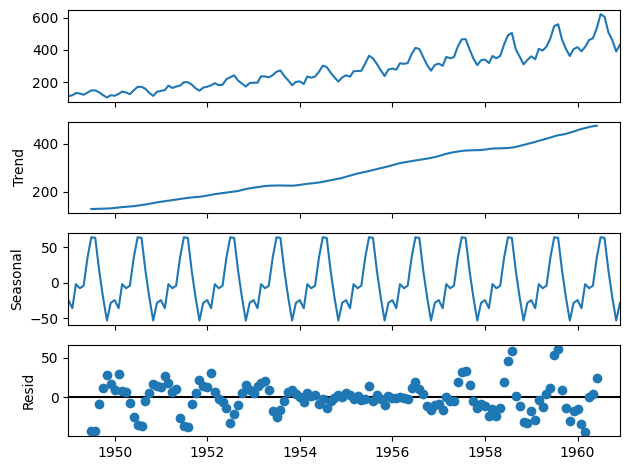

In [13]:
decomposition = seasonal_decompose(df, model = 'addative')
decomposition.plot()
plt.show()

In [14]:
trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

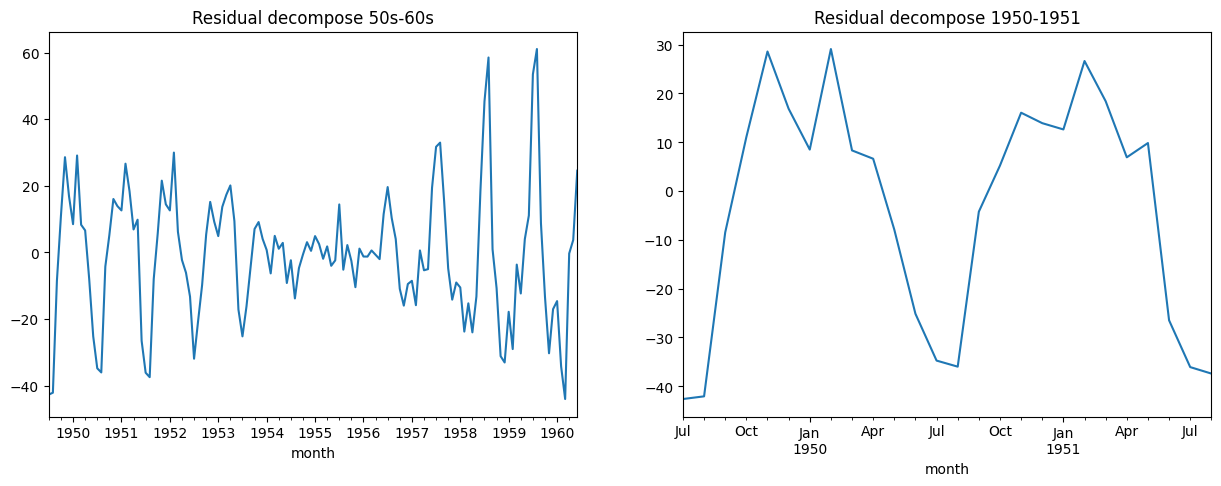

In [15]:
residual_part = residual_part.dropna()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (15, 5))
residual_part.plot(ax = ax1)
residual_part['1949-07-01':'1951-08-01'].plot(ax = ax2)
ax1.set_title('Residual decompose 50s-60s')
ax2.set_title('Residual decompose 1950-1951')
plt.show()

<a id = 'factors'></a>
# Factors

<a id = 'window_functions'></a>
## Window Functions in Pandas

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
df = pd.read_csv('Upload/15.8.csv')
df['ts'] = pd.to_datetime(df.ts)
df = df.iloc[1000:1100]
df.reset_index(drop = True, inplace = True)
df.head()

,ts,open,high,low,close,vol
0,2018-01-02 18:42:00,1314.3,1314.4,1313.9,1313.9,323
1,2018-01-02 18:43:00,1314.0,1314.2,1314.0,1314.0,177
2,2018-01-02 18:44:00,1314.0,1314.0,1313.7,1313.9,216
3,2018-01-02 18:45:00,1313.9,1314.1,1313.8,1314.0,170
4,2018-01-02 18:46:00,1314.0,1314.1,1314.0,1314.0,186


In [18]:
def myMax(value):
    return max(value)

df['rolling_mean'] = df.close.rolling(window = 5).mean()
df['rolling_std'] = df.close.rolling(window = 5).std()
df['rolling_max'] = df.close.rolling(window = 5).apply(myMax, raw = False)

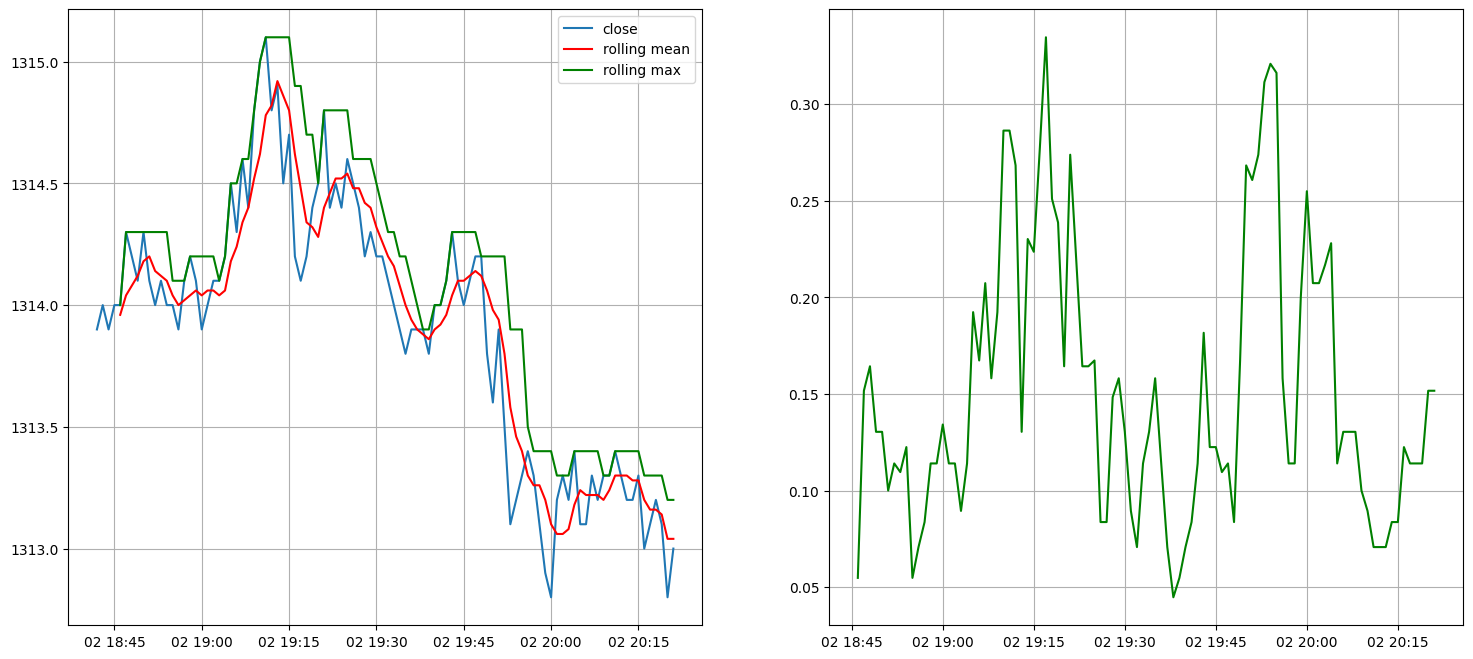

,ts,open,high,low,close,vol,rolling_mean,rolling_std,rolling_max
0,2018-01-02 18:42:00,1314.3,1314.4,1313.9,1313.9,323,NaN,NaN,NaN
1,2018-01-02 18:43:00,1314.0,1314.2,1314.0,1314.0,177,NaN,NaN,NaN
2,2018-01-02 18:44:00,1314.0,1314.0,1313.7,1313.9,216,NaN,NaN,NaN
3,2018-01-02 18:45:00,1313.9,1314.1,1313.8,1314.0,170,NaN,NaN,NaN
4,2018-01-02 18:46:00,1314.0,1314.1,1314.0,1314.0,186,1313.96,0.054772,1314.0
5,2018-01-02 18:47:00,1314.0,1314.3,1314.0,1314.3,99,1314.04,0.151658,1314.3
6,2018-01-02 18:48:00,1314.3,1314.4,1314.2,1314.2,99,1314.08,0.164317,1314.3
7,2018-01-02 18:49:00,1314.2,1314.2,1314.1,1314.1,113,1314.12,0.130384,1314.3
8,2018-01-02 18:50:00,1314.2,1314.3,1314.1,1314.3,129,1314.18,0.130384,1314.3
9,2018-01-02 18:51:00,1314.4,1314.4,1314.1,1314.1,139,1314.20,0.100000,1314.3


In [19]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(df.ts, df.close)
ax[0].plot(df.ts, df.rolling_mean, c='r')
ax[0].plot(df.ts, df.rolling_max,  c='g')
ax[0].legend(['close', 'rolling mean', 'rolling max'])
ax[0].grid()

ax[1].plot(df.ts, df.rolling_std, c='g') ## оконное стандартное отклонение
ax[1].grid()
plt.show()

df.head(12)

<a id = 'moving_average'></a>
## Moving Average

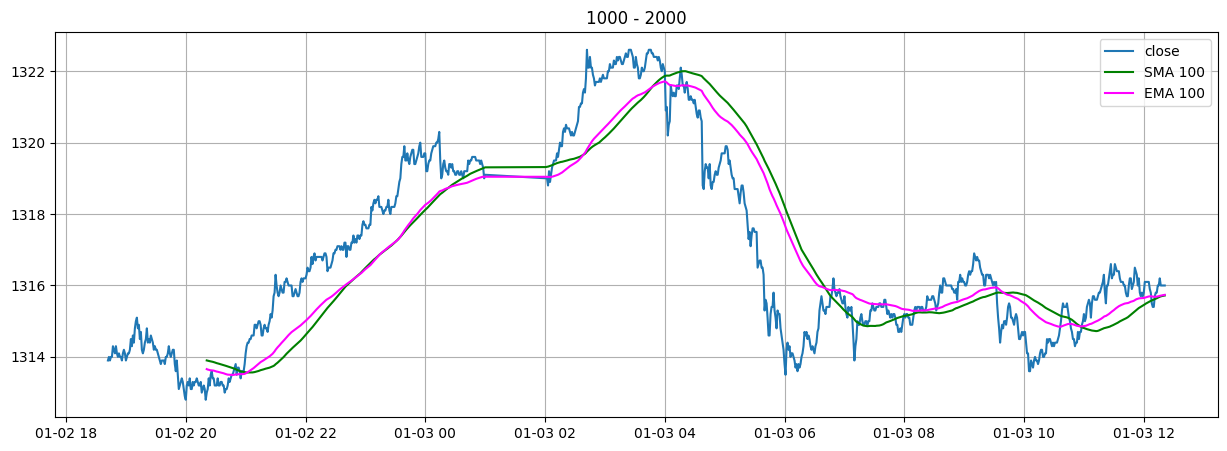

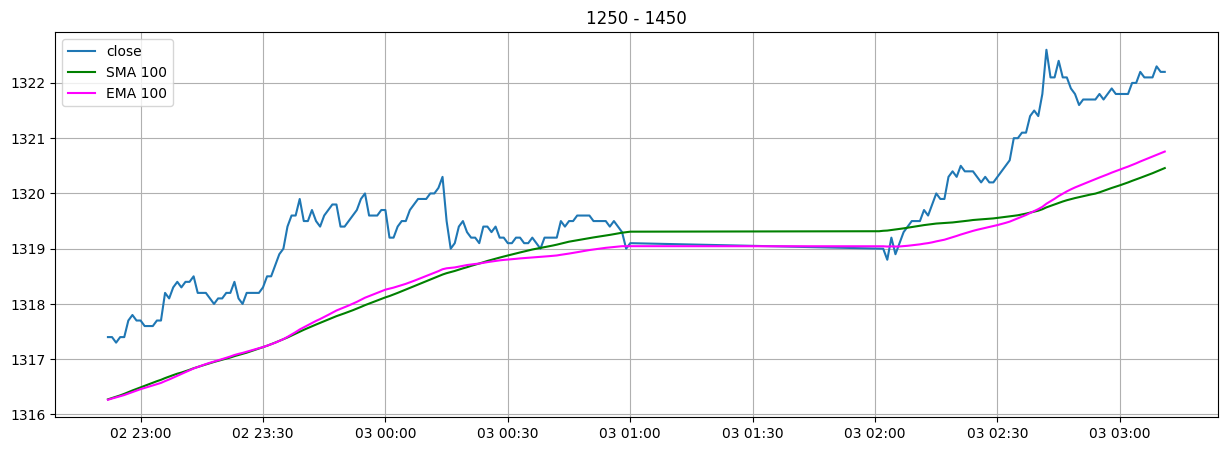

In [20]:
df = pd.read_csv('Upload/15.8.csv')
df['ts'] = pd.to_datetime(df.ts)
df = df.iloc[1000:2000]

df['rolling_mean_100'] = df.close.rolling(window = 100).mean()
df['rolling_ema_100'] = df.close.ewm(min_periods = 100, span = 100).mean()

fig, axes = plt.subplots(1, 1, figsize = (15,5))

axes.plot(df.ts, df['close'])
axes.plot(df.ts, df['rolling_mean_100'], c = 'g')
axes.plot(df.ts, df['rolling_ema_100'], c = 'magenta')
axes.legend(['close', 'SMA 100', 'EMA 100'])
axes.set_title('1000 - 2000')
axes.grid()

fig, axes = plt.subplots(1, 1, figsize = (15,5))

axes.plot(df.ts[250:450], df['close'][250:450])
axes.plot(df.ts[250:450], df['rolling_mean_100'][250:450], c = 'g')
axes.plot(df.ts[250:450], df['rolling_ema_100'][250:450], c = 'magenta')
axes.legend(['close', 'SMA 100', 'EMA 100'])
axes.set_title('1250 - 1450')
axes.grid()

plt.show()

<a id = 'lags'></a>
## Lags

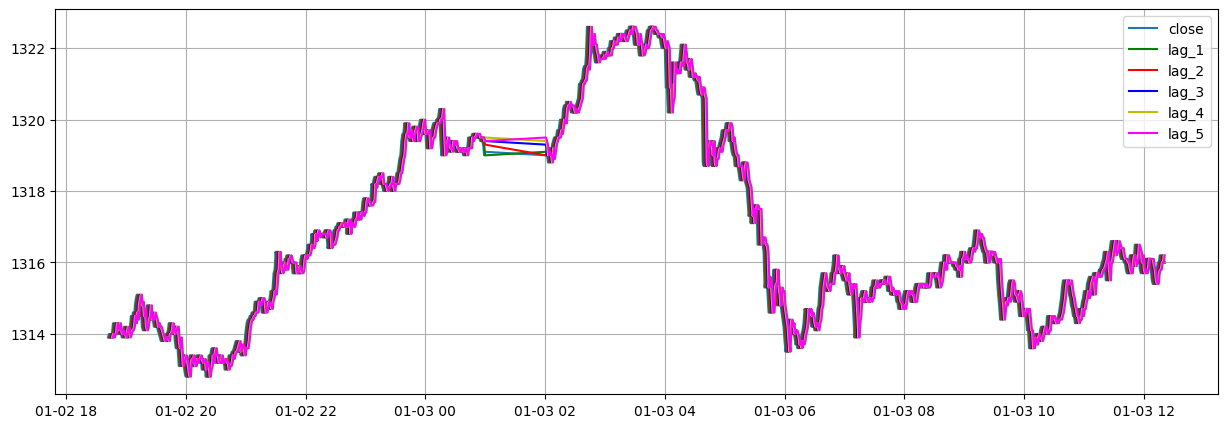

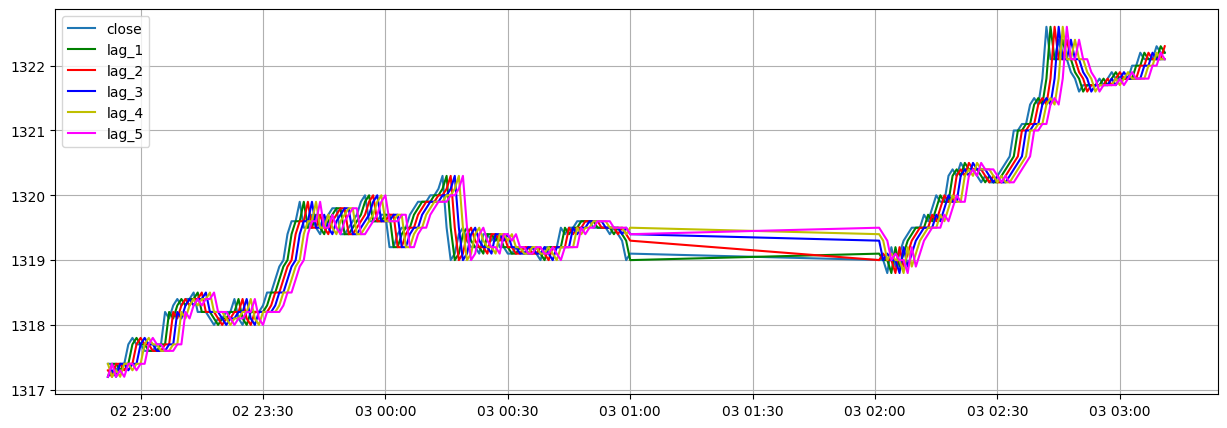

In [21]:
for i in range(1,6):
    df['lag_{}'.format(i)] = df.close.shift(i)


f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df.ts, df.close)
ax.plot(df.ts, df['lag_' + str(1)],  c='g') 
ax.plot(df.ts, df['lag_' + str(2)],  c='r') 
ax.plot(df.ts, df['lag_' + str(3)],  c='b') 
ax.plot(df.ts, df['lag_' + str(4)],  c='y') 
ax.plot(df.ts, df['lag_' + str(5)],  c='magenta') 
ax.legend(['close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])
ax.grid()

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df.ts[250:450], df.close[250:450])
ax.plot(df.ts[250:450], df['lag_' + str(1)][250:450],  c='g') 
ax.plot(df.ts[250:450], df['lag_' + str(2)][250:450],  c='r') 
ax.plot(df.ts[250:450], df['lag_' + str(3)][250:450],  c='b') 
ax.plot(df.ts[250:450], df['lag_' + str(4)][250:450],  c='y') 
ax.plot(df.ts[250:450], df['lag_' + str(5)][250:450],  c='magenta') 
ax.legend(['close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])
ax.grid()

<hr style="border:1px solid gray">

<a id = 'ar_model'></a>
# AR (Autoregressive) model

<a id = 'random_time_series'></a>
## Random generated time series

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

## Generate time series data

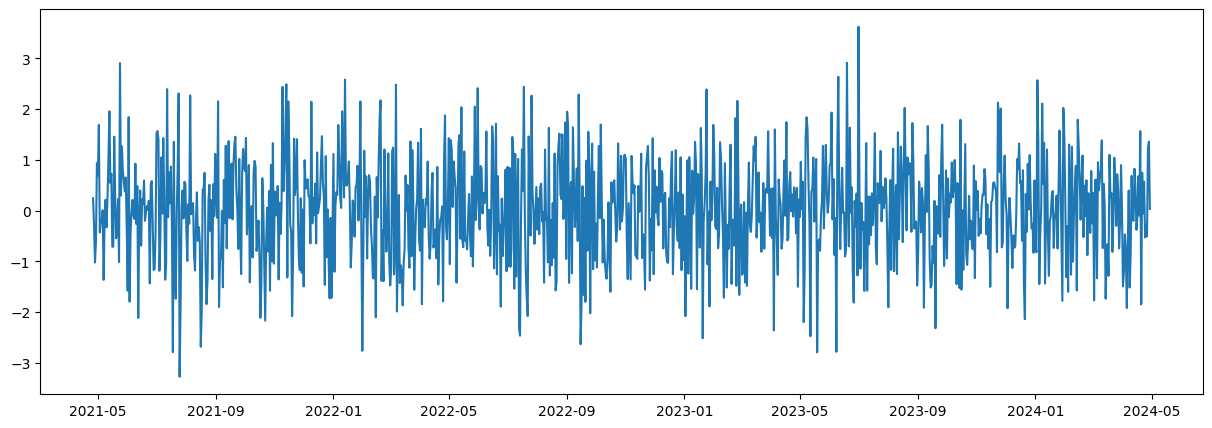

In [43]:
num = 1100

date_today = datetime.datetime.today()
date_list = pd.to_datetime([date_today - datetime.timedelta(days = x) for x in range(num)]).date

generator = np.random.default_rng(seed = 11)
y = generator.standard_normal((num, 1))
z = generator.random((num, 1))

df_test = pd.DataFrame(np.c_[y, z], columns = ['close', 'open'], index = pd.DatetimeIndex(date_list))
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(df_test.index, df_test['close'])
plt.show()

## Analyse time series data

### Check the distribution inside different windows

[DIST 1 - DIST 2]: 0.979
[DIST 2 - DIST 3]: 0.414
[DIST 1 - DIST 3]: 0.708


<Axes: xlabel='close', ylabel='Density'>

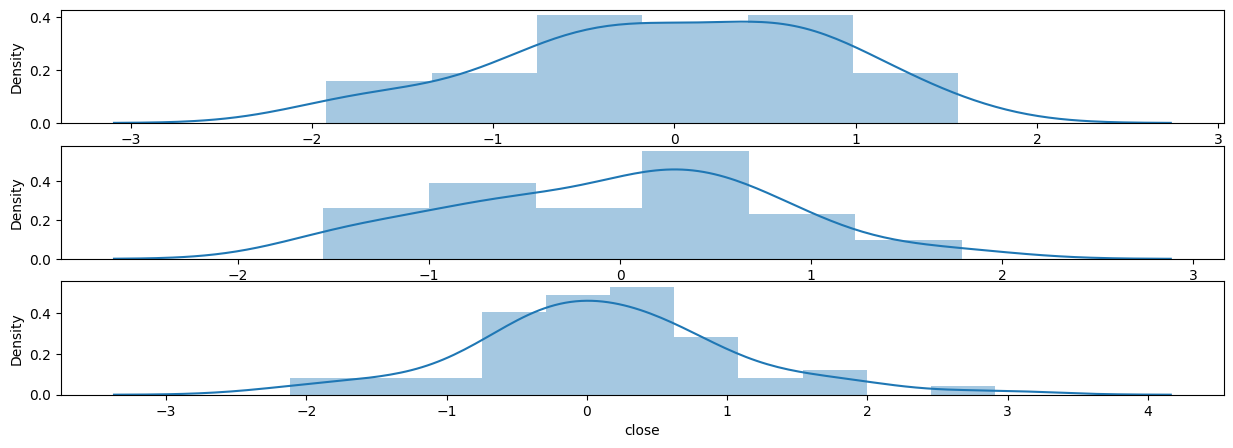

In [44]:
import seaborn as sns
from scipy.stats import ks_2samp

dist_split_1 = df_test.iloc[:int(len(df_test) * .05)]['close']
dist_split_2 = df_test.iloc[int(len(df_test) * .15):int(len(df_test) * .2)]['close']
dist_split_3 = df_test.iloc[-int(len(df_test) * .05):-1]['close']

print(f'[DIST 1 - DIST 2]: {ks_2samp(dist_split_1, dist_split_2)[1]:.3f}')
print(f'[DIST 2 - DIST 3]: {ks_2samp(dist_split_2, dist_split_3)[1]:.3f}')
print(f'[DIST 1 - DIST 3]: {ks_2samp(dist_split_1, dist_split_3)[1]:.3f}')

fig, ax = plt.subplots(3, 1, figsize = (15, 5))
sns.distplot(dist_split_1, ax = ax[0])
sns.distplot(dist_split_2, ax = ax[1])
sns.distplot(dist_split_3, ax = ax[2])

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> By comparing the similarity of the distributions within the selected windows, we can assume that the time series has strong stationarity.
    </p>
</div>

### Decomposition

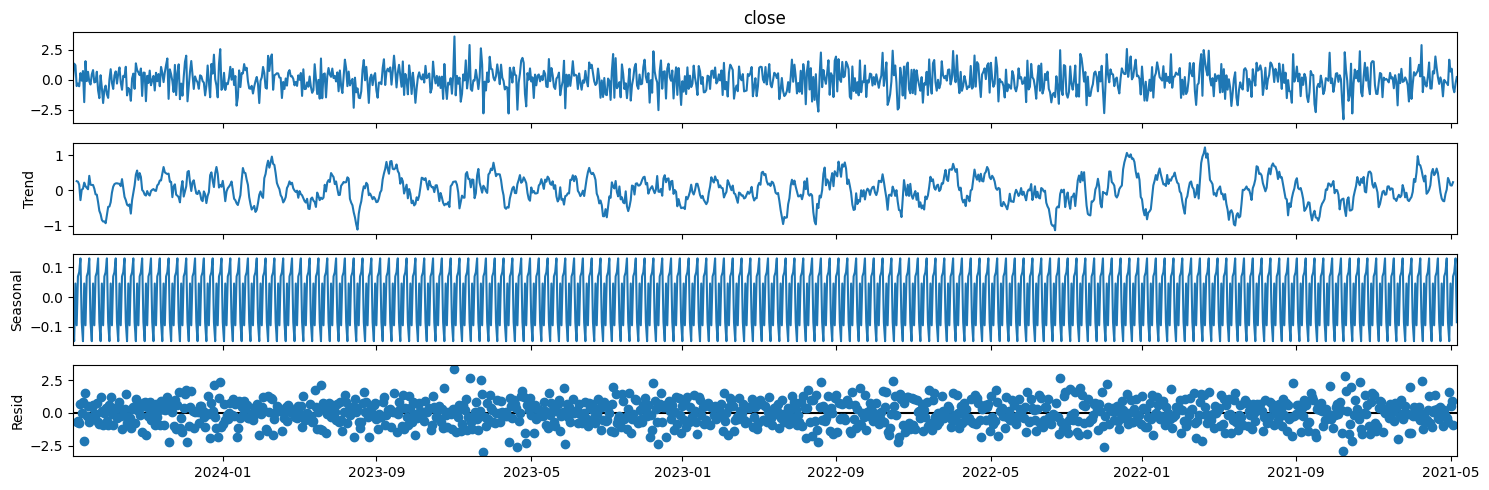

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposer = seasonal_decompose(df_test['close'], model = 'additive')

fig = decomposer.plot()
fig.set_size_inches((15, 5))
fig.tight_layout()
plt.show()

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> The decomposition of the time series excludes trend and seasonal effects, indicating that the time series contain stationarity.
    </p>
</div>

### Adfuller Test

In [46]:
from statsmodels.tsa.stattools import adfuller

adfuller_test = adfuller(df_test['close'])

print(f'1. Critical Value: {adfuller_test[0]:.2f}')
print(f'2. P-Value: {adfuller_test[1]:.3f}')
print(f'3. Lags used in the regression to determine T-statistic: {adfuller_test[2]}')
print(f'4. Number of observations used in the analysis: {adfuller_test[3]}')
print(f'5. T-values corresponding to adfuller test:')
for key, val in adfuller_test[4].items():
    print(f'\t → {key} : {val:.2f}')

1. Critical Value: -33.26
2. P-Value: 0.000
3. Lags used in the regression to determine T-statistic: 0
4. Number of observations used in the analysis: 1099
5. T-values corresponding to adfuller test:
	 → 1% : -3.44
	 → 5% : -2.86
	 → 10% : -2.57


<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> We reject the null hypothesis in favour of the alternative hypothesis that the time series contains stationarity.
    </p>
</div>

### ACF and PACF

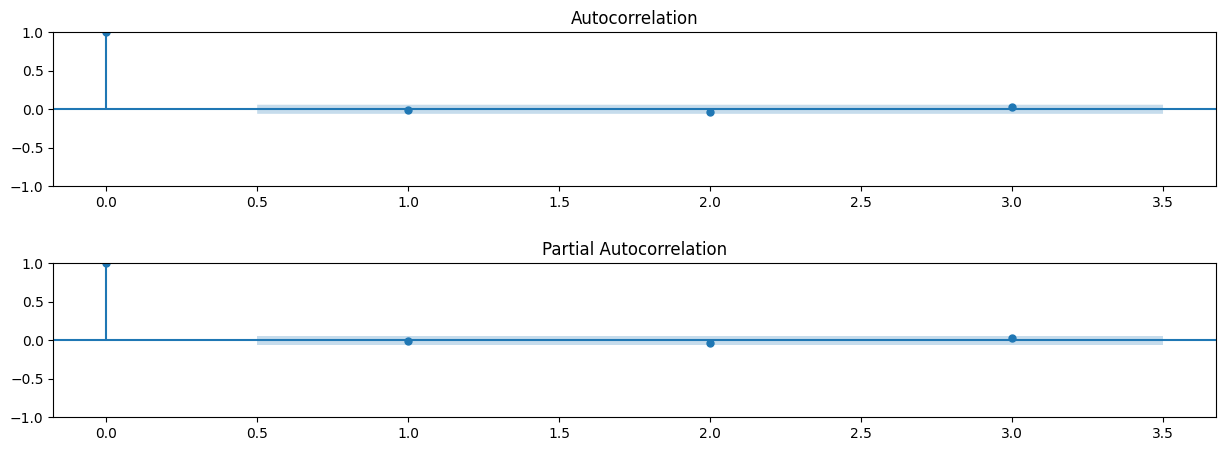

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize = (15, 5))
plot_acf(df_test['close'], lags = 3, ax = ax[0])
plot_pacf(df_test['close'], lags = 3, ax = ax[1])
fig.subplots_adjust(hspace = .5)
plt.show()

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> We see that both autocorrelation functions show low lag effect on forecasting. Therefore, we'll use the constant variable and set the parameter lags = 0.
    </p>
</div>

### AR select order

In [48]:
from statsmodels.tsa.ar_model import ar_select_order

ar_select_order(df_test['close'], maxlag = 12).ar_lags

### Train and Test

In [49]:
df_test = df_test.sort_index()
x_train = df_test[:int(len(df_test) * .3)]
x_test = df_test[int(len(df_test) * .3):]

### AutoReg (AR)

In [50]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(x_train['close'], lags = 0).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                  330
Model:                     AutoReg(0)   Log Likelihood                -485.808
Method:               Conditional MLE   S.D. of innovations              1.055
Date:                Mon, 29 Apr 2024   AIC                            975.615
Time:                        20:53:50   BIC                            983.214
Sample:                    04-26-2021   HQIC                           978.646
                         - 03-21-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.058      0.068      0.946      -0.110       0.118


<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> The p-value indicates low significance of the constant.
    </p>
</div>

[RMSE]: 0.98


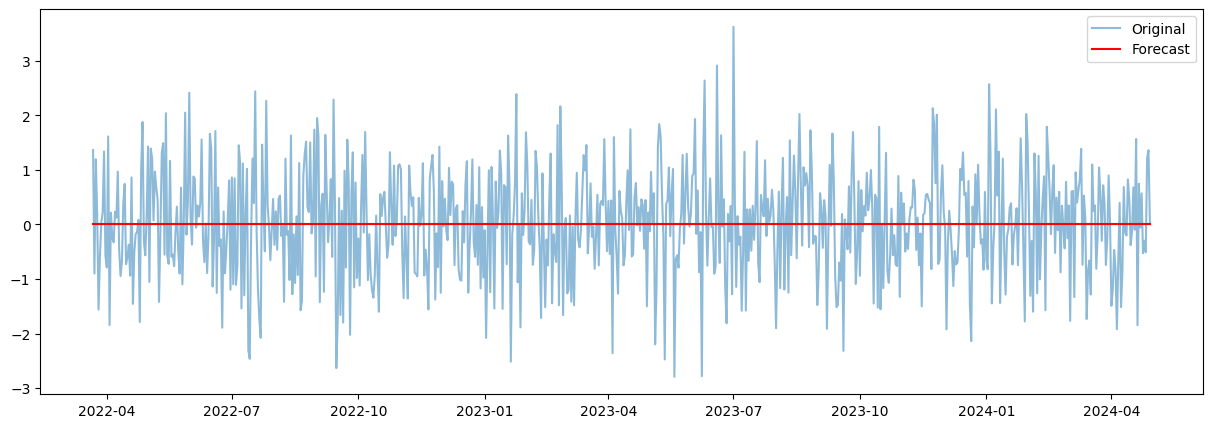

In [51]:
from sklearn.metrics import mean_squared_error

forecast = model.predict(start = len(x_train), end = len(df_test) - 1, dynamic = False)

rmse = np.sqrt(mean_squared_error(x_test['close'], forecast))
print(f'[RMSE]: {rmse:.2f}')

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(x_test['close'], alpha = .5)
ax.plot(forecast, c = 'r')
ax.legend(['Original', 'Forecast'])
plt.show()

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> The AR model forecasted the test time series data by using the constant mean of the time series.
    </p>
</div>

<hr style="border:1px solid gray">

<a id = 'stock'></a>
# STOCK time series data

In [52]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

from scipy.stats import ks_2samp

In [53]:
df = pd.read_csv('Upload/15.8.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.set_index('ts').sort_index()

## Distribution

[DIST 1] - [DIST 2]: 0.000 , [MEAN]: 1317.04 - 1325.53, [STD]: 4.41 - 10.63
[DIST 2] - [DIST 3]: 0.000 , [MEAN]: 1325.53 - 1275.46, [STD]: 10.63 - 6.95
[DIST 1] - [DIST 3]: 0.000 , [MEAN]: 1317.04 - 1275.46, [STD]: 4.41 - 6.95


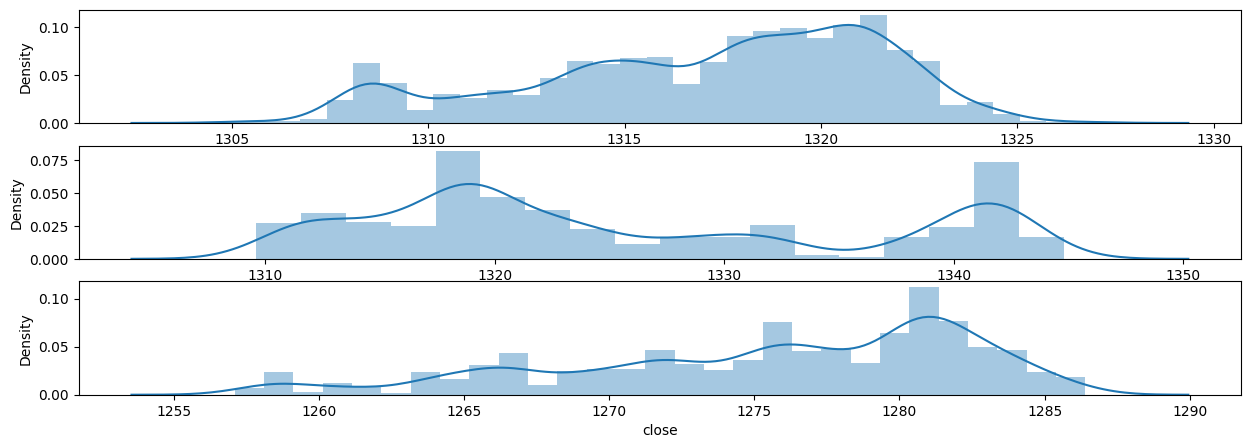

In [54]:
dist_split_1 = df.iloc[:int(len(df) * .02)]['close']
dist_split_2 = df.iloc[int(len(df) * .02):int(len(df) * .04)]['close']
dist_split_3 = df.iloc[-int(len(df) * .02):]['close']

print(f'[DIST 1] - [DIST 2]: {ks_2samp(dist_split_1, dist_split_2)[1]:.3f} \
, [MEAN]: {dist_split_1.mean():.2f} - {dist_split_2.mean():.2f}, [STD]: {dist_split_1.std():.2f} - {dist_split_2.std():.2f}')
print(f'[DIST 2] - [DIST 3]: {ks_2samp(dist_split_2, dist_split_3)[1]:.3f} \
, [MEAN]: {dist_split_2.mean():.2f} - {dist_split_3.mean():.2f}, [STD]: {dist_split_2.std():.2f} - {dist_split_3.std():.2f}')
print(f'[DIST 1] - [DIST 3]: {ks_2samp(dist_split_1, dist_split_3)[1]:.3f} \
, [MEAN]: {dist_split_1.mean():.2f} - {dist_split_3.mean():.2f}, [STD]: {dist_split_1.std():.2f} - {dist_split_3.std():.2f}')


fig, ax = plt.subplots(3, 1, figsize = (15,5))
sns.distplot(dist_split_1, ax = ax[0])
sns.distplot(dist_split_2, ax = ax[1])
sns.distplot(dist_split_3, ax = ax[2])
plt.show()

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> The distributions are not similar, which rules out the assumption of strong stationarity. There is also a large difference between the moving averages and the standard distribution, which rules out weak stationarity. 
    </p>
</div>

## Decomposition

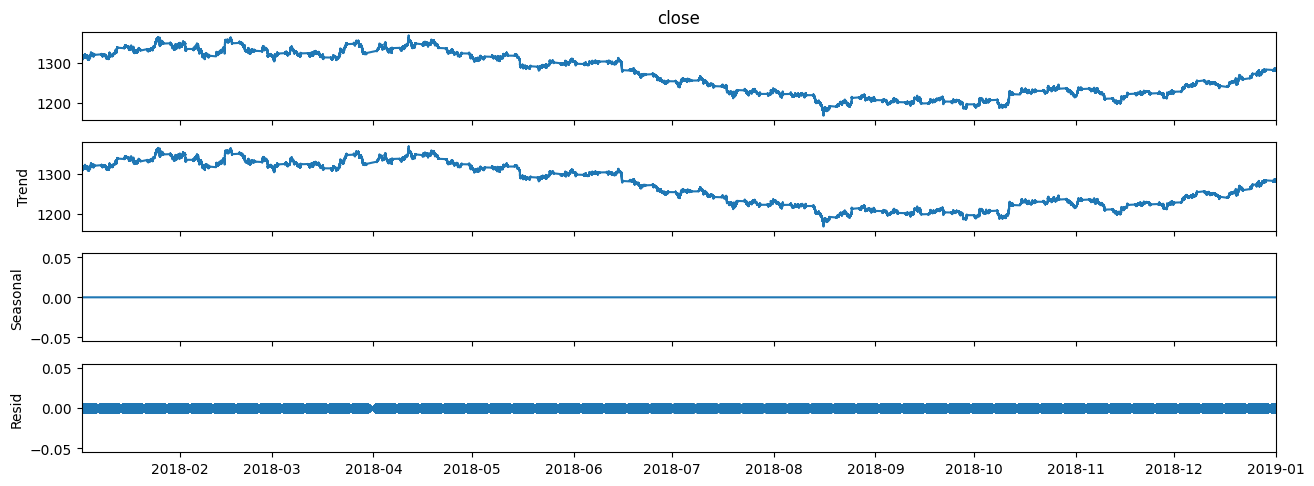

In [55]:
decompose = seasonal_decompose(df['close'], period = 1)

fig = decompose.plot()
fig.set_size_inches((15, 5))
plt.show()

<div class = 'alert alert-info'>
    <p>
        <b>Interpretation:</b> The time series data show a significant trend. 
    </p>
</div>

## Adfuller Test

In [56]:
adfuller_test = adfuller(df['close'])

In [57]:
print(f'1. Critical Value: {adfuller_test[0]:.2f}')
print(f'2. P-Value: {adfuller_test[1]:.3f}')
print(f'3. Lags used in the regression to determine T-statistic: {adfuller_test[2]}')
print(f'4. Number of observations used in the analysis: {adfuller_test[3]}')
print(f'5. T-values corresponding to adfuller test:')
for key, val in adfuller_test[4].items():
    print(f'\t → {key} : {val:.2f}')

1. Critical Value: -1.30
2. P-Value: 0.629
3. Lags used in the regression to determine T-statistic: 64
4. Number of observations used in the analysis: 350386
5. T-values corresponding to adfuller test:
	 → 1% : -3.43
	 → 5% : -2.86
	 → 10% : -2.57


<hr style="border:1px solid gray">

<a id = 'autoreg_non_stationary'></a>
# AutoReg on non-stationary time series

### Differencing: Order 1

To create the need to differentiate the target value, we'll use a range of data (0:30000).

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

In [59]:
# Upload data, set datetime index
data = pd.read_csv('Upload/15.8.csv')
data['date'] = pd.to_datetime(data['ts'])
data = data.set_index(pd.DatetimeIndex(data['date'])).drop(columns = ['ts', 'date'])
#data = data['close']

#### plot

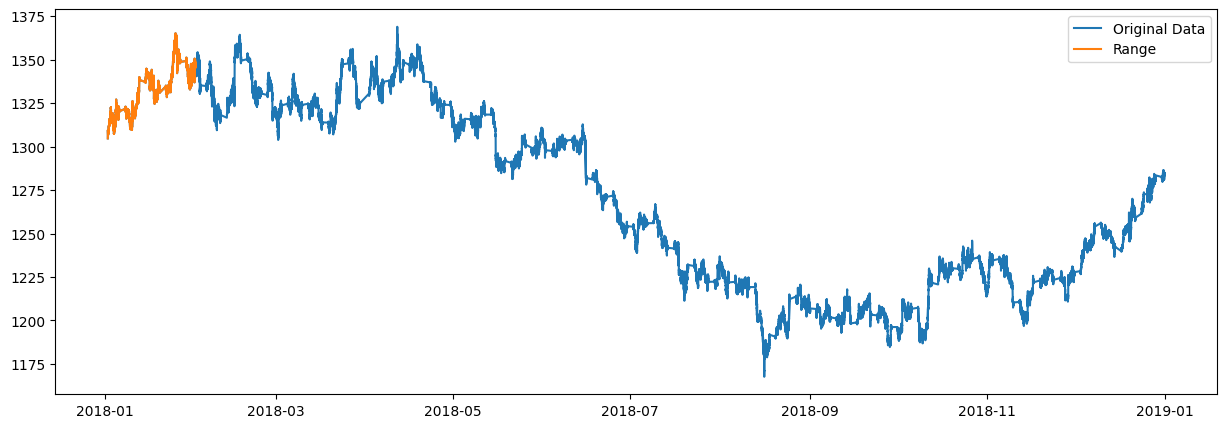

In [60]:
# Plot data
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(data.index, data['close'])
# Used range
ax.plot(data.iloc[0:30000].index, data.iloc[0:30000]['close'])
ax.legend(['Original Data', 'Range'])
plt.show()

#### adfuller

In [61]:
test = data.iloc[0:30000]

adfuller_close = adfuller(test['close'])
print(f'1. ADF - Critical Value: {adfuller_close[0]:.2f}')
print(f'2. P-Value: Reject HA (NOT reject H0): {adfuller_close[1]:.4f} → The TIME SERIES is NOT STATIONARY')
print(f'3. Lags used for regression: {adfuller_close[2]}')
print(f'4. Observations used in the analysis: {adfuller_close[3]}')
print(f'5. T-values corresponding to Adfuller Test:')
for key, val in adfuller_close[4].items():
    print(f'\t ► {key} : {val:.2f}')

1. ADF - Critical Value: -1.92
2. P-Value: Reject HA (NOT reject H0): 0.3213 → The TIME SERIES is NOT STATIONARY
3. Lags used for regression: 3
4. Observations used in the analysis: 29996
5. T-values corresponding to Adfuller Test:
	 ► 1% : -3.43
	 ► 5% : -2.86
	 ► 10% : -2.57


#### cut range

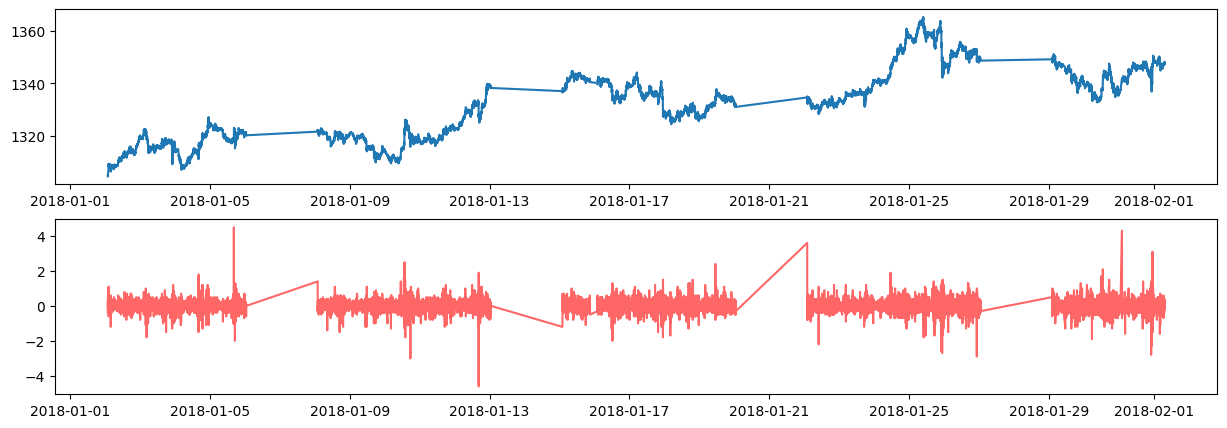

In [62]:
# Use differencing method
#fill_val = data.iloc[0]['close']
fill_val = data['close'].rolling(window = 5).mean().dropna()[0]
data['shift1'] = data['close'].shift(1).fillna(fill_val)
data['difference'] = data['close'] - data['shift1']

# Range the dataset and plot the close and difference columns
test = data.iloc[0:30000]
fig, ax = plt.subplots(2, 1, figsize = (15, 5))
ax[0].plot(test.index, test['close'])
ax[1].plot(test['difference'], c = 'r', alpha = .6)
plt.show()

#### Use Adfuller test to check if the difference column is stationary

In [63]:
adfuller_diff = adfuller(test['difference'])
print(f'1. ADF - Critical Value: {adfuller_diff[0]:.2f}')
print(f'2. P-Value: Reject HA (NOT reject H0): {adfuller_diff[1]:.4f} → The TIME SERIES is STATIONARY')
print(f'3. Lags used for regression: {adfuller_diff[2]}')
print(f'4. Observations used in the analysis: {adfuller_diff[3]}')
print(f'5. T-values corresponding to Adfuller Test:')
for key, val in adfuller_diff[4].items():
    print(f'\t ► {key} : {val:.2f}')

1. ADF - Critical Value: -104.83
2. P-Value: Reject HA (NOT reject H0): 0.0000 → The TIME SERIES is STATIONARY
3. Lags used for regression: 2
4. Observations used in the analysis: 29997
5. T-values corresponding to Adfuller Test:
	 ► 1% : -3.43
	 ► 5% : -2.86
	 ► 10% : -2.57


#### ACF and PACF

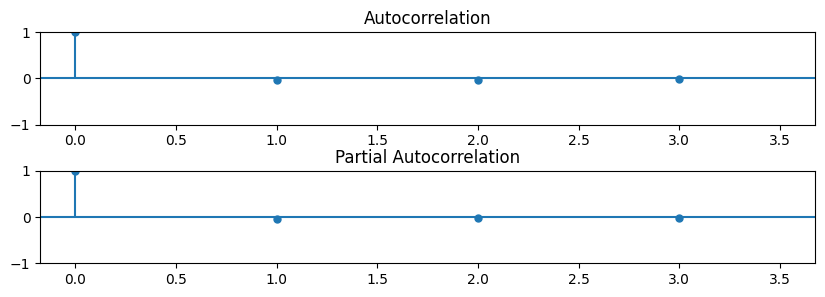

In [64]:
# ACF
fig, ax = plt.subplots(2, 1, figsize = (10, 3))
plot_acf(test['difference'], lags = 3, ax = ax[0])
plot_pacf(test['difference'], lags = 3, ax = ax[1])
plt.subplots_adjust(hspace = .5, wspace = .5)
plt.show()

#### Select Order

In [65]:
selected_lags = ar_select_order(test['difference'], maxlag = 12).ar_lags
print(f'Number of Lags: {selected_lags}')

Number of Lags: [1, 2]


#### Testing AutoReg on Differenced Data

In [66]:
# Train and Test split
x_train, x_test = np.split(test, [int(len(test) * .7)])

model = AutoReg(x_train['difference'], lags = selected_lags).fit()

print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:             difference   No. Observations:                21000
Model:                     AutoReg(2)   Log Likelihood                 579.907
Method:               Conditional MLE   S.D. of innovations              0.235
Date:                Mon, 29 Apr 2024   AIC                          -1151.815
Time:                        20:54:54   BIC                          -1120.006
Sample:                             2   HQIC                         -1141.433
                                21000                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.002      0.976      0.329      -0.002       0.005
difference.L1    -0.0544      0.007     -7.890      0.000      -0.068      -0.041
difference.L2    -0.0401      0.007     

#### Predict x_test

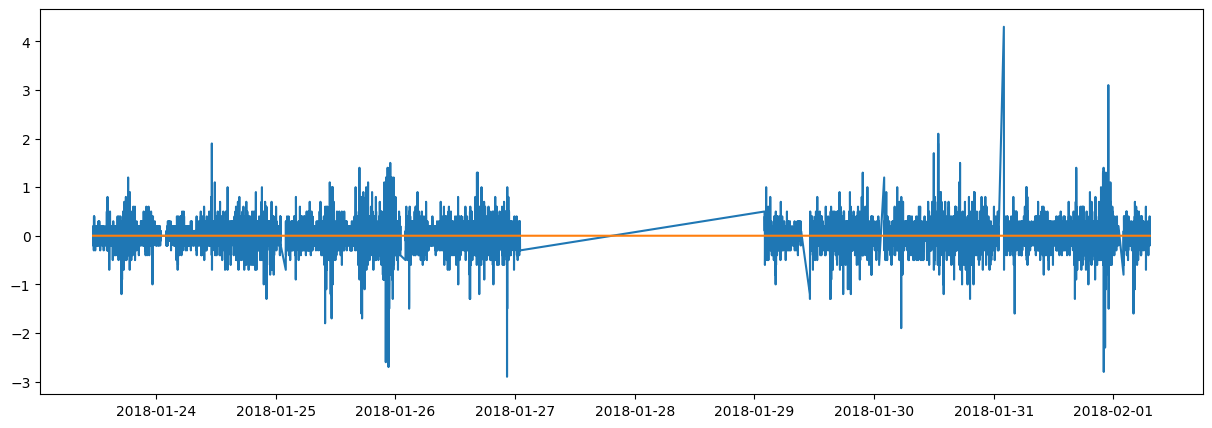

In [67]:
pred = pd.DataFrame(model.predict(start = len(x_train), end = len(test)-1)
                    , columns = ['difference']).set_index(x_test.index)

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(x_test.index, x_test['difference'])
ax.plot(pred.index, pred['difference'])
plt.show()

<hr style="border:1px solid gray">

<a id = 'autoreg_stationary'></a>
# AutoReg on stationary time series

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [69]:
df = pd.read_csv('Upload/15.8.csv')

#### plot

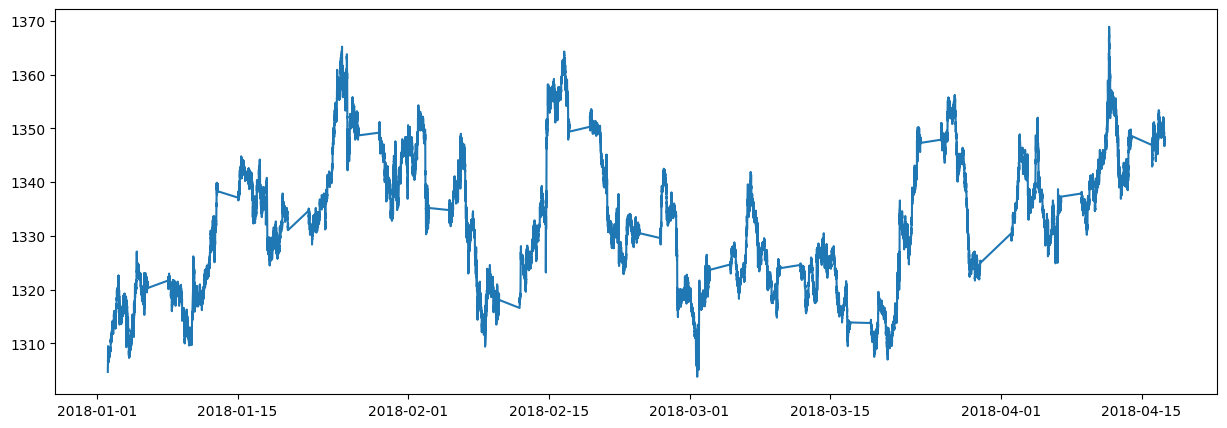

In [70]:
test = df.copy()
test = test.iloc[0:100000]

test = test.set_index(pd.DatetimeIndex(test['ts'])).sort_index()
test.index = test.index.rename('datetimeindex')
test = test.drop(columns = test.columns.difference(['close']))

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(test.index, test['close'])
plt.show()

#### decompose

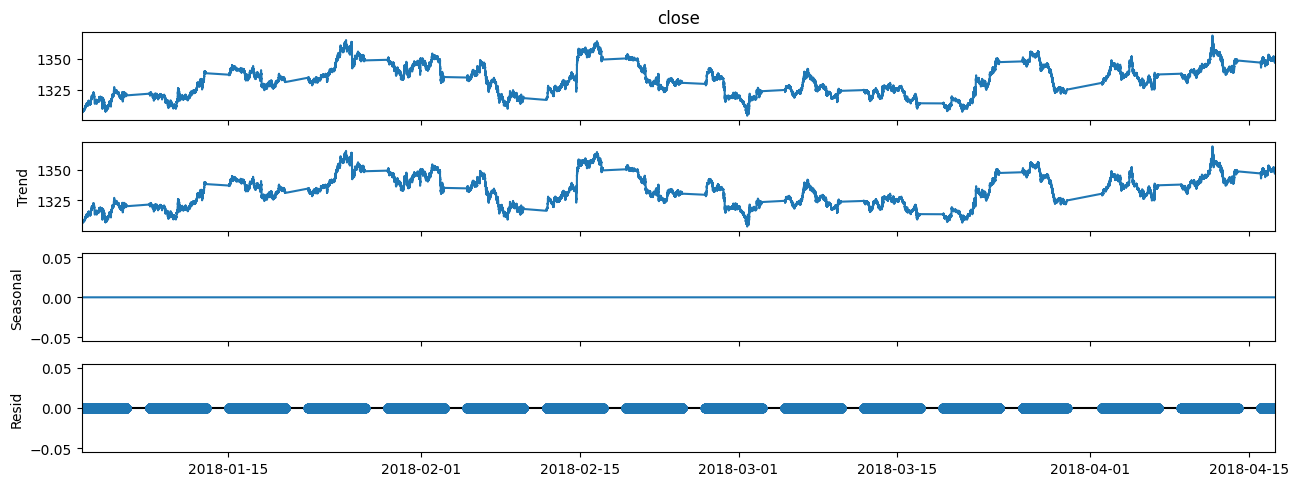

In [71]:
decomposer = seasonal_decompose(test['close'], period = 1)
fig = decomposer.plot()
fig.set_size_inches((15, 5))
plt.show()

#### adfuller

In [72]:
adfuller_test = adfuller(test.iloc[:100000]['close'])
print(f'1. ADF - Critical Value: {adfuller_test[0]:.2f}')
print(f'2. P-Value: Reject HA (NOT reject H0): {adfuller_test[1]:.4f} → The TIME SERIES is stationary')
print(f'3. Lags used for regression: {adfuller_test[2]}')
print(f'4. Observations used in the analysis: {adfuller_test[3]}')
print(f'5. T-values corresponding to Adfuller Test:')
for key, val in adfuller_test[4].items():
    print(f'\t ► {key} : {val:.2f}')

1. ADF - Critical Value: -3.29
2. P-Value: Reject HA (NOT reject H0): 0.0154 → The TIME SERIES is stationary
3. Lags used for regression: 11
4. Observations used in the analysis: 99988
5. T-values corresponding to Adfuller Test:
	 ► 1% : -3.43
	 ► 5% : -2.86
	 ► 10% : -2.57


#### ACF and PACF

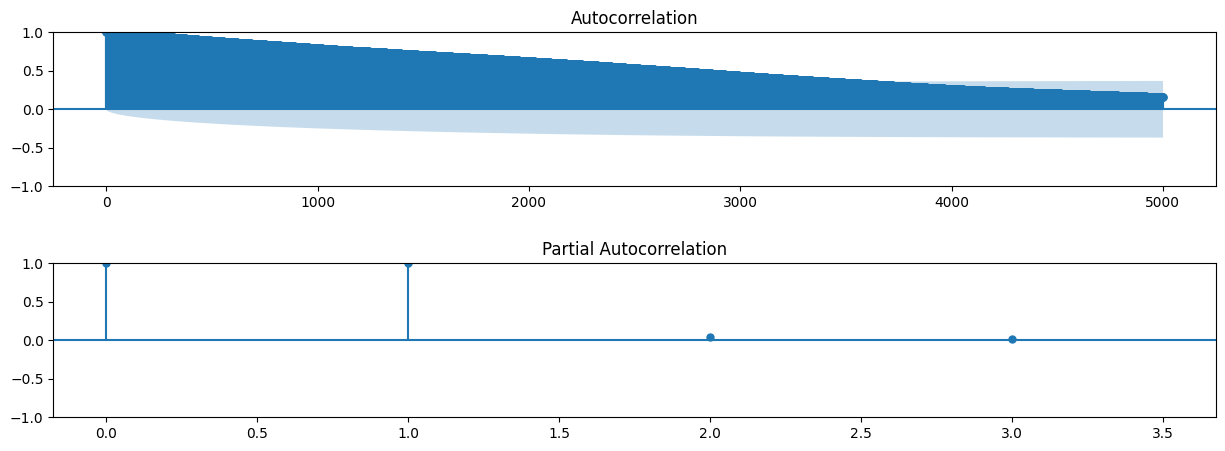

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize = (15, 5))
plot_acf(test['close'], lags = 5000, ax = ax[0])
plot_pacf(test['close'], lags = 3, ax = ax[1])
fig.subplots_adjust(hspace = .5, wspace = .5)
plt.show()

#### Select Order

In [74]:
selected_lags = ar_select_order(test['close'], maxlag = 12).ar_lags
print(f'Number of Lags: {selected_lags}')

Number of Lags: [1, 2, 3]


#### AutoReg

In [75]:
x_train, x_test = np.split(test, [int(len(test) * .7)])

model = AutoReg(x_train['close'], lags = selected_lags).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                70000
Model:                     AutoReg(3)   Log Likelihood               -5513.333
Method:               Conditional MLE   S.D. of innovations              0.262
Date:                Mon, 29 Apr 2024   AIC                          11036.667
Time:                        20:55:04   BIC                          11082.448
Sample:                             3   HQIC                         11050.787
                                70000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3110      0.104      2.976      0.003       0.106       0.516
close.L1       0.9521      0.004    251.944      0.000       0.945       0.960
close.L2       0.0297      0.005      5.689      0.0

#### predict

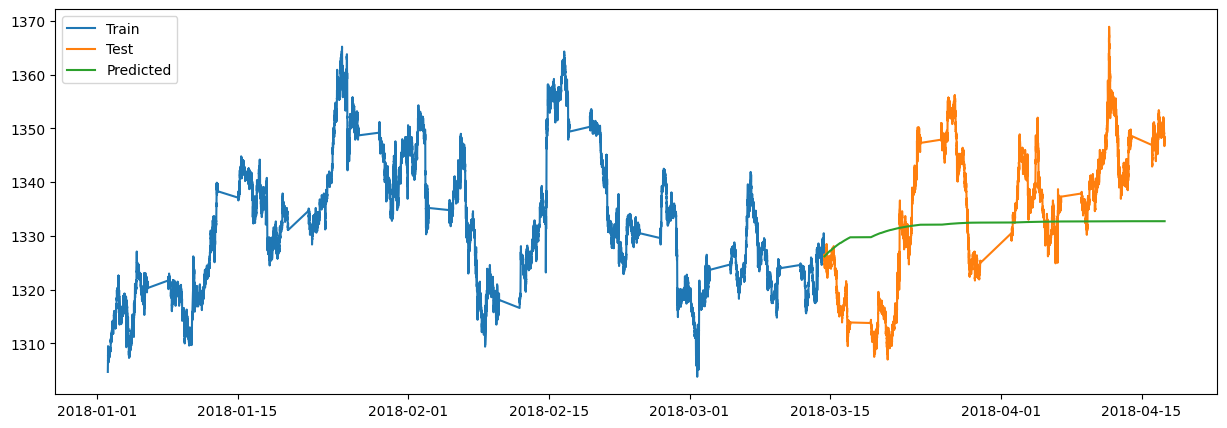

In [76]:
pred = pd.DataFrame(model.predict(start = len(x_train), end = len(test) - 1, dynamic = False), columns = ['close'])
pred = pred.set_index(x_test.index)

fig, ax = plt.subplots(1, 1, figsize = (15, 5))

ax.plot(x_train.index, x_train['close'])
ax.plot(x_test.index, x_test['close'])
ax.plot(pred.index, pred['close'])
ax.legend(['Train', 'Test', 'Predicted'])
plt.show()

<hr style="border:1px solid gray">

<a id = 'arima_sarima'></a>
# ARIMA/SARIMA

<a id = 'ma_linreg'></a>
## MA and LinearRegression

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [78]:
df = pd.read_csv('Upload/15.10.csv')

### Data

In [79]:
df['date'] = pd.to_datetime(df['date'])
df = df[df.columns[2:]]

test = df[df['item_nbr'] == 265559]

import warnings
warnings.filterwarnings(action = 'ignore')

# Get date features
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

### distribution

In [80]:
df_time = test.groupby(['date']).agg({'unit_sales':'sum'}).sort_index()

In [81]:
# Cut outlier
df_time = df_time.iloc[:-4]

[DIST 1] - [DIST 2]: 0.888 , [MEAN]: 2075.35 - 2001.43, [STD]: 842.81 - 470.47
[DIST 2] - [DIST 3]: 0.422 , [MEAN]: 2001.43 - 2256.65, [STD]: 470.47 - 733.52
[DIST 1] - [DIST 3]: 0.888 , [MEAN]: 2075.35 - 2256.65, [STD]: 842.81 - 733.52


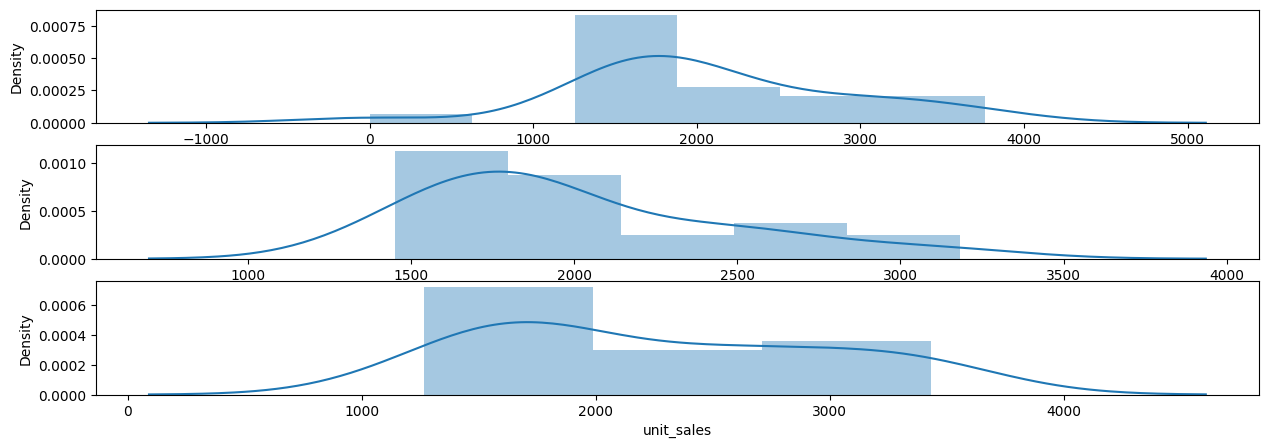

In [82]:
dist_split_1 = df_time.iloc[int(len(df_time)*.0):int(len(df_time)*.2)]['unit_sales']
dist_split_2 = df_time.iloc[int(len(df_time)*.3):int(len(df_time)*.5)]['unit_sales']
dist_split_3 = df_time.iloc[int(len(df_time)*.6):int(len(df_time)*.8)]['unit_sales']

print(f'[DIST 1] - [DIST 2]: {ks_2samp(dist_split_1, dist_split_2)[1]:.3f} \
, [MEAN]: {dist_split_1.mean():.2f} - {dist_split_2.mean():.2f}, [STD]: {dist_split_1.std():.2f} - {dist_split_2.std():.2f}')
print(f'[DIST 2] - [DIST 3]: {ks_2samp(dist_split_2, dist_split_3)[1]:.3f} \
, [MEAN]: {dist_split_2.mean():.2f} - {dist_split_3.mean():.2f}, [STD]: {dist_split_2.std():.2f} - {dist_split_3.std():.2f}')
print(f'[DIST 1] - [DIST 3]: {ks_2samp(dist_split_1, dist_split_3)[1]:.3f} \
, [MEAN]: {dist_split_1.mean():.2f} - {dist_split_3.mean():.2f}, [STD]: {dist_split_1.std():.2f} - {dist_split_3.std():.2f}')


fig, ax = plt.subplots(3, 1, figsize = (15,5))
sns.distplot(dist_split_1, ax = ax[0])
sns.distplot(dist_split_2, ax = ax[1])
sns.distplot(dist_split_3, ax = ax[2])
plt.show()

### adfuller

In [83]:
adfuller_test = adfuller(df_time['unit_sales'])
print(f'1. ADF - Critical Value: {adfuller_test[0]:.2f}')
print(f'2. P-Value: Reject HA (NOT reject H0): {adfuller_test[1]:.4f}')
print(f'3. Lags used for regression: {adfuller_test[2]}')
print(f'4. Observations used in the analysis: {adfuller_test[3]}')
print(f'5. T-values corresponding to Adfuller Test:')
for key, val in adfuller_test[4].items():
    print(f'\t ► {key} : {val:.2f}')
    
if adfuller_test[1] <= .05:
    print(f'→ The TIME SERIES is stationary')
else:
    print(f'→ The TIME SERIES is NOT stationary')

1. ADF - Critical Value: -1.95
2. P-Value: Reject HA (NOT reject H0): 0.3077
3. Lags used for regression: 13
4. Observations used in the analysis: 103
5. T-values corresponding to Adfuller Test:
	 ► 1% : -3.50
	 ► 5% : -2.89
	 ► 10% : -2.58
→ The TIME SERIES is NOT stationary


### MA (moving average)

In [84]:
def time_series_ma(series, window_size):
    '''Create prediction using MA
    
    Args:
        series (series): Series of data values
        window_size (int): Size of the window
    
    Return:
        array: An array of ma with the given window size
    '''
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

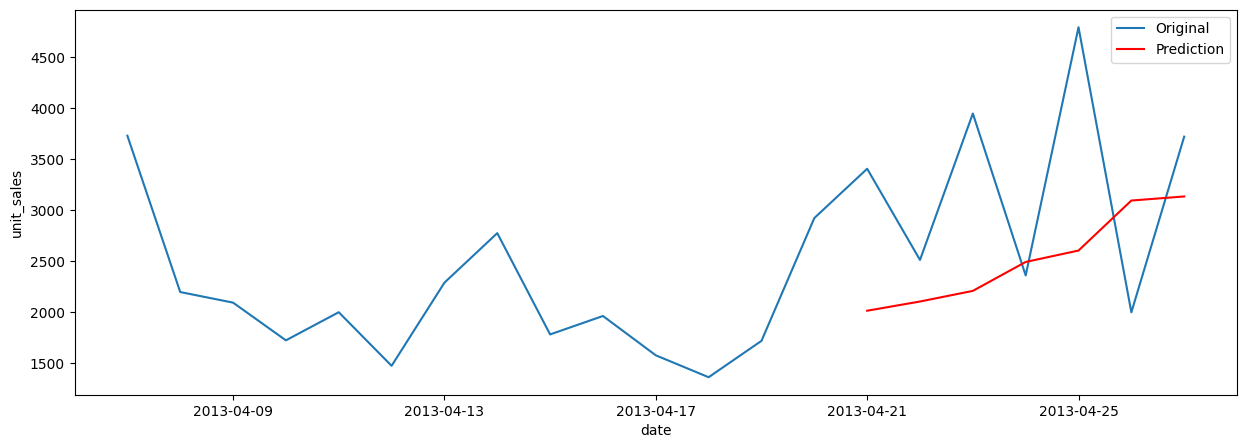

[RMSE]: 738.89, [MAPE]: 0.27


In [85]:
# Forecast using MA
ma_window = 7

#series_ma = time_series_ma(df_time['unit_sales'], ma_window)
series_ma = time_series_ma(df_time, ma_window)
df_ma = pd.DataFrame(series_ma, columns = ['prediction'], index = df_time[ma_window:].index)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(df_time[-ma_window * 3:]['unit_sales'], label='Original')
sns.lineplot(df_ma[-ma_window:]['prediction'], color = 'r', label='Prediction')
plt.legend(loc="upper right")
plt.show()

# RMSE and MAPE
df_ma['unit_sales'] = df_time[-int(len(df_ma)):]['unit_sales']
ma_mape = mean_absolute_percentage_error(df_ma['prediction'], df_ma['unit_sales'])
ma_rmse = np.sqrt(mean_squared_error(df_ma['prediction'], df_ma['unit_sales']))

print(f'[RMSE]: {ma_rmse:.2f}, [MAPE]: {ma_mape:.2f}')

### LinearRegression

[INTERCEPT]: 2032.78, [COEF]: [ 0.34609092  0.17407449 -0.33139729 -0.06154485 -0.05356593 -0.25577291
  0.21851857]


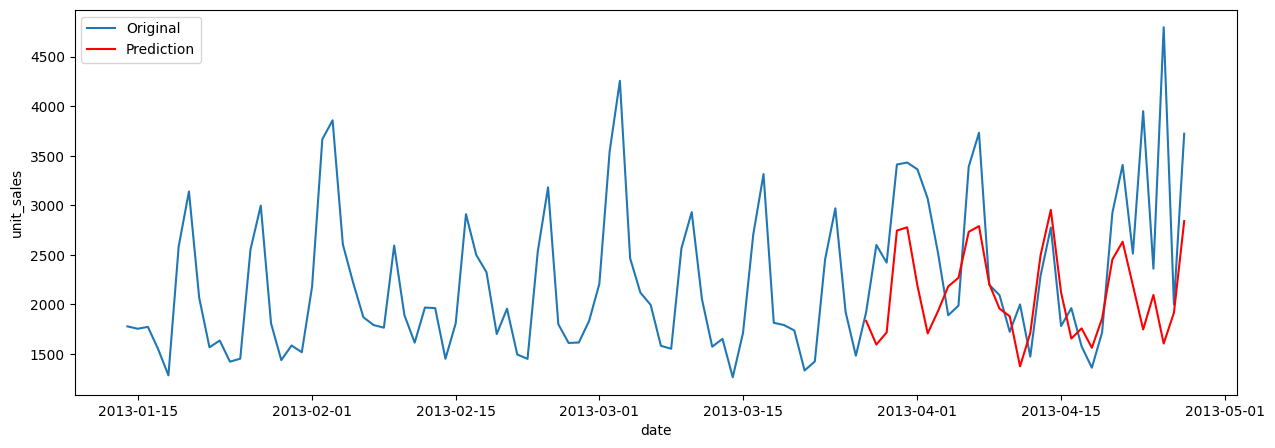

[RMSE]: 885.99, [MAPE]: 0.20


In [86]:
# DataFrame
df_lin = df_time.copy()
for shift in range(7, 14):
    df_lin['shift'+str(shift)] = df_lin['unit_sales'].shift(shift)

df_lin.dropna(inplace = True)

# Train Test Split
train, test = np.split(df_lin, [int(len(df_lin)*0.7)])
x_train, y_train =  train.drop(columns = ['unit_sales']), train['unit_sales']
x_test, y_test =  test.drop(columns = ['unit_sales']), test['unit_sales']

# LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

# Prediction
pred = model.predict(x_test)
test['pred'] = pred

print(f'[INTERCEPT]: {model.intercept_:.2f}, [COEF]: {model.coef_}')

# Plot
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(df_lin['unit_sales'], label = 'Original')
sns.lineplot(test['pred'], color = 'r', label = 'Prediction')
ax.legend(loc = 'upper left')
plt.show()

# RMSE and MAPE
lin_rmse = np.sqrt(mean_squared_error(test['unit_sales'],test['pred']))
lin_mape = mean_absolute_percentage_error(test['unit_sales'],test['pred'])
print(f'[RMSE]: {lin_rmse:.2f}, [MAPE]: {lin_mape:.2f}')

### OLS (ordinary least squares)

In [87]:
X = df_lin.drop(columns = ['unit_sales'])
y = df_lin['unit_sales']

model_ols = sm.OLS(y, X)
ols_sum = model_ols.fit()
print(ols_sum.summary())

                                 OLS Regression Results                                
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                              149.7
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                    4.39e-49
Time:                        20:55:08   Log-Likelihood:                         -826.98
No. Observations:                 104   AIC:                                      1668.
Df Residuals:                      97   BIC:                                      1686.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<a id = 'acf_pacf'></a>
## ACF and PACF

In [352]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Итак, чтобы построить ARIMA модель нам нужно знать ее порядок, состоящий из 3-х параметров:
    
    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA
    
d мы уже знаем - это 0

осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

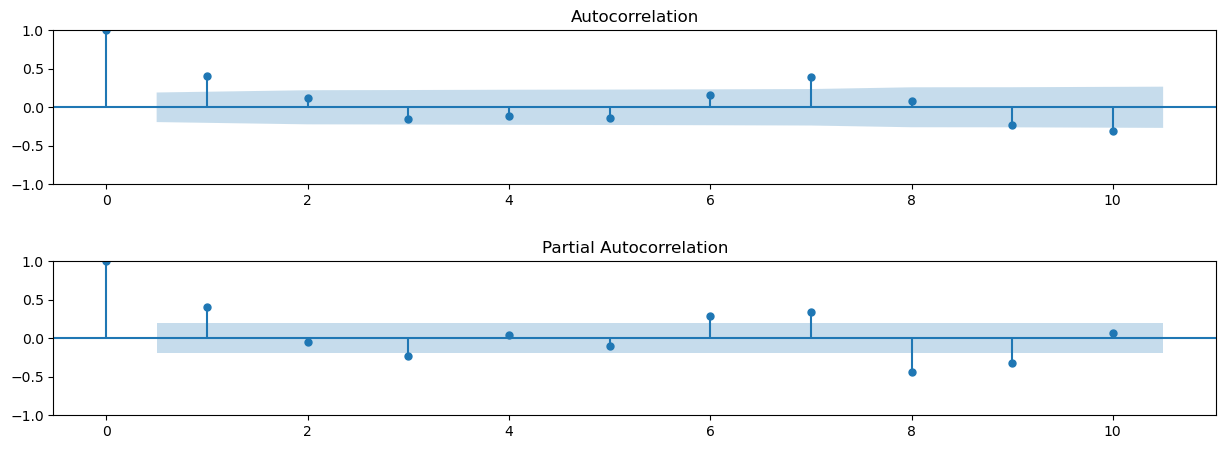

[AR(p) - PACF]: 6, [MA(q) - ACF]: 6


In [353]:
# PLOT ACF and PACF
fig, ax = plt.subplots(2, 1, figsize = (15, 5))
plot_acf(df_lin['unit_sales'], lags = 10, ax = ax[0])
plot_pacf(df_lin['unit_sales'], lags = 10, ax = ax[1])
fig.subplots_adjust(hspace = .5)
plt.show()

print(f'[AR(p) - PACF]: 6, [MA(q) - ACF]: 6')

<a id = 'arima'></a>
## ARIMA

In [354]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

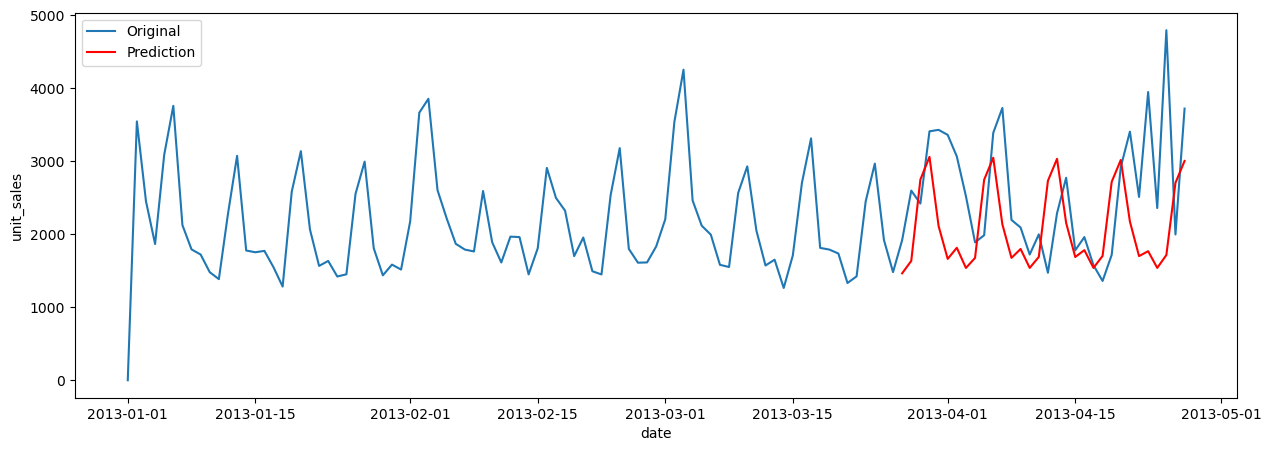

[RMSE]: 1032.06, [MAPE]: 0.41


In [355]:
train_size = len(y_train)
test_size = len(y_test)

# ARIMA
arima_model = ARIMA(y_train.values.reshape(-1), order = (6, 0, 6))
arima_model = arima_model.fit()
pred = arima_model.predict(start = train_size, end = train_size + test_size, dynamic = False)
test['pred'] = pred[1:]

# PLOT
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(df_time['unit_sales'], label = 'Original')
sns.lineplot(test['pred'], color = 'r', label = 'Prediction')
plt.show()

# RMSE and MAPE
arima_rmse = np.sqrt(mean_squared_error(test['pred'], test['unit_sales']))
arima_mape = mean_absolute_percentage_error(test['pred'], test['unit_sales'])

print(f'[RMSE]: {arima_rmse:.2f}, [MAPE]: {arima_mape:.2f}')

<a id = 'arima_summary'></a>
## Summary

In [364]:
rmse = [ma_rmse, lin_rmse, arima_rmse]
mape = [ma_mape, lin_mape, arima_mape]

pd.DataFrame(np.round([rmse, mape], 2)
             , columns = ['MA', 'LinReg', 'ARIMA']
             , index = ['RMSE', 'MAPE'])

,MA,LinReg,ARIMA
RMSE,738.89,885.99,1032.06
MAPE,0.27,0.20,0.41


[UP](#toc)

<a id = 'xgboost'></a>
# XGBoost

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from scipy.stats import ks_2samp
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

### Data

Data contains hourly power consumption from PJM.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [121]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

In [122]:
df = pd.read_csv('Upload/15.14.csv', parse_dates = [0])

df.columns = df.columns.str.lower()
df = df.set_index('datetime')
df = df.rename(columns = {'pjme_mw':'pjme'})

In [123]:
# Create date features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['date'] = df.index.date

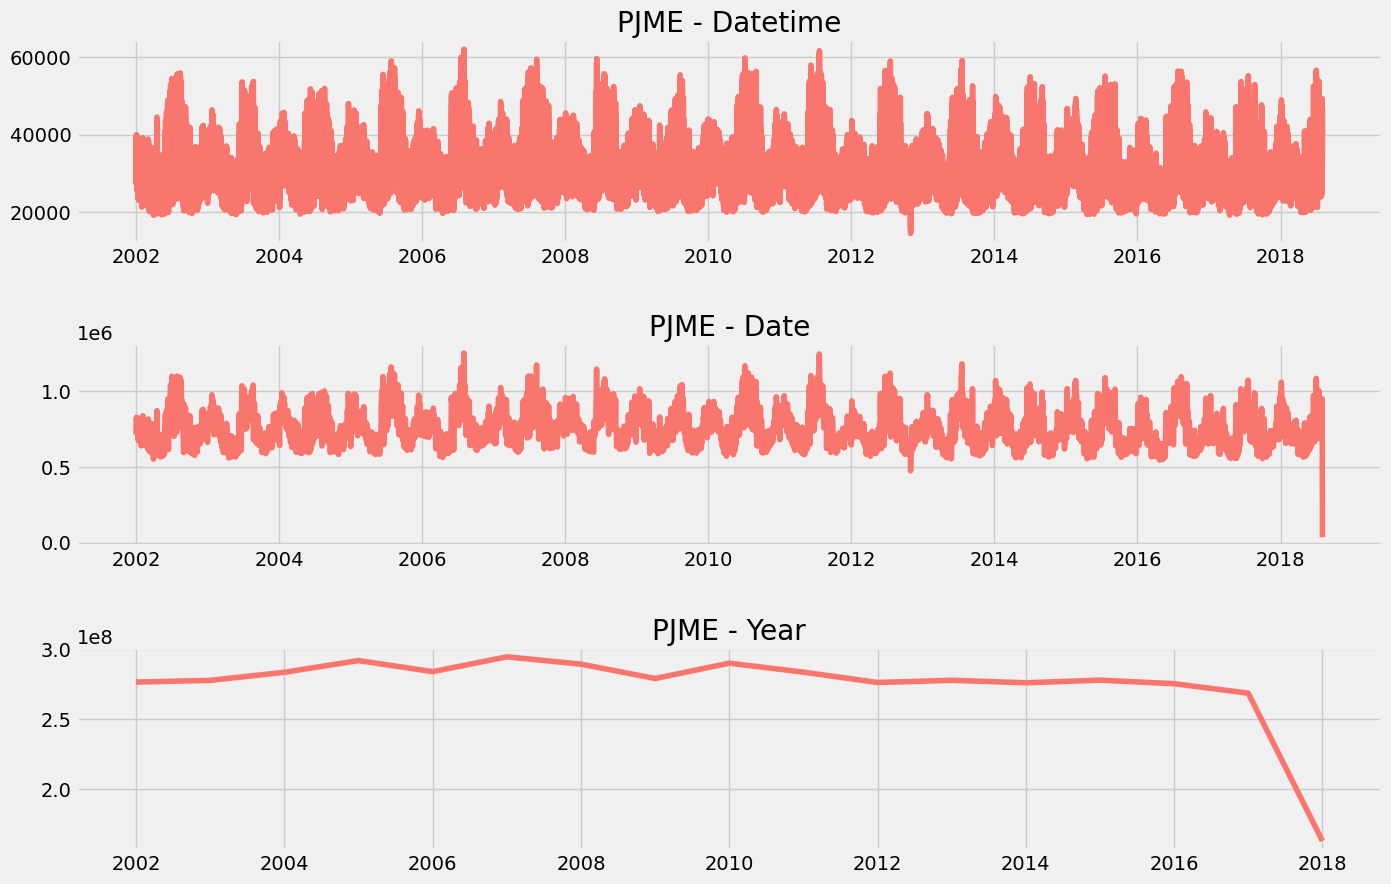

In [124]:
# Create grouped dataframes to plot
plot_by_date = df.groupby(['date']).agg({'pjme':'sum'})
plot_by_year = df.groupby(['year']).agg({'pjme':'sum'})

# Plot
fig, ax = plt.subplots(3, 1, figsize = (15, 10))
ax[0].plot(df['pjme'], color=color_pal[0])
ax[1].plot(plot_by_date, color=color_pal[0])
ax[2].plot(plot_by_year, color=color_pal[0])

ax[0].set_title('PJME - Datetime')
ax[1].set_title('PJME - Date')
ax[2].set_title('PJME - Year')
plt.subplots_adjust(hspace = .5)
plt.show()

### Distirubution

[DIST 1] - [DIST 2]: 0.000, [MEAN]: 31752.87 - 33255.82 , [STD]: 6311.77 - 6741.70
[DIST 1] - [DIST 2]: 0.000, [MEAN]: 33255.82 - 32557.09 , [STD]: 6741.70 - 7031.16
[DIST 1] - [DIST 2]: 0.000, [MEAN]: 31752.87 - 32557.09 , [STD]: 6311.77 - 7031.16


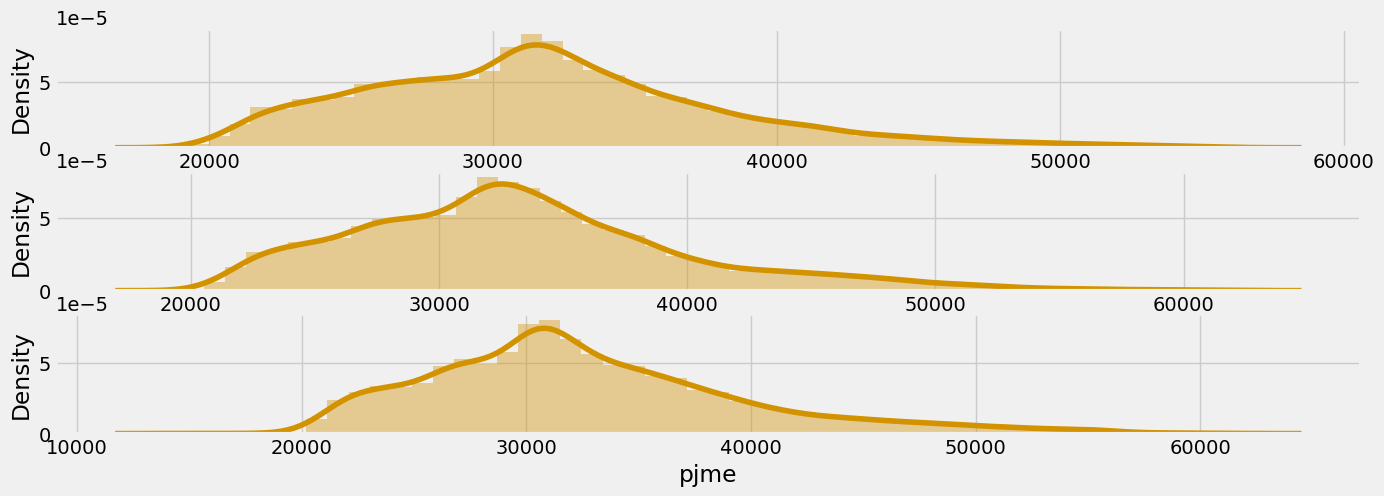

In [125]:
# Select samples by percentage length
dist_split_1 = df.iloc[0:int(len(df)*.15)]['pjme']
dist_split_2 = df.iloc[int(len(df)*.25):int(len(df)*.40)]['pjme']
dist_split_3 = df.iloc[int(len(df)*.50):int(len(df)*.65)]['pjme']

# Print distribution properties
def dist_split(ds1, ds2):
    '''Return compared distributions'''
    
    print(f'[DIST 1] - [DIST 2]: {ks_2samp(ds1, ds2)[1]:.3f}, [MEAN]: {ds1.mean():.2f} - {ds2.mean():.2f} \
, [STD]: {ds1.std():.2f} - {ds2.std():.2f}')
    
dist_split(dist_split_1, dist_split_2)
dist_split(dist_split_2, dist_split_3)
dist_split(dist_split_1, dist_split_3)

# Plot
fig, ax = plt.subplots(3, 1, figsize = (15,5))
sns.distplot(dist_split_1, ax = ax[0], color = color_pal[1])
sns.distplot(dist_split_2, ax = ax[1], color = color_pal[1])
sns.distplot(dist_split_3, ax = ax[2], color = color_pal[1])
plt.show()

### Adfuller

In [7]:
adfuller_test = adfuller(df['pjme'])
print(f'1. ADF - Critical Value: {adfuller_test[0]:.2f}')
print(f'2. P-Value: Reject HA (NOT reject H0): {adfuller_test[1]:.4f}')
print(f'3. Lags used for regression: {adfuller_test[2]}')
print(f'4. Observations used in the analysis: {adfuller_test[3]}')
print(f'5. T-values corresponding to Adfuller Test:')
for key, val in adfuller_test[4].items():
    print(f'\t ► {key} : {val:.2f}')
    
if adfuller_test[1] <= .05:
    print(f'→ The TIME SERIES is stationary')
else:
    print(f'→ The TIME SERIES is NOT stationary')

1. ADF - Critical Value: -18.83
2. P-Value: Reject HA (NOT reject H0): 0.0000
3. Lags used for regression: 74
4. Observations used in the analysis: 145291
5. T-values corresponding to Adfuller Test:
	 ► 1% : -3.43
	 ► 5% : -2.86
	 ► 10% : -2.57
→ The TIME SERIES is stationary


### Features

In [126]:
def create_features(df, target_col):
    '''
    Creates time series features from datetime index
    '''
    
    X = df.copy()
    
    X['date'] = X.index
    X['hour'] = X['date'].dt.hour
    X['dayofweek'] = X['date'].dt.dayofweek
    X['quarter'] = X['date'].dt.quarter
    X['month'] = X['date'].dt.month
    X['year'] = X['date'].dt.year
    X['dayofyear'] = X['date'].dt.dayofyear
    X['dayofmonth'] = X['date'].dt.day
    X[str(target_col) + '_6_hrs_lag'] = X[target_col].shift(6)
    X[str(target_col) + '_12_hrs_lag'] = X[target_col].shift(12)
    X[str(target_col) + '_24_hrs_lag'] = X[target_col].shift(24)
    X[str(target_col) + '_6_hrs_mean'] = X[target_col].rolling(window = 6).mean()
    X[str(target_col) + '_12_hrs_mean'] = X[target_col].rolling(window = 12).mean()
    X[str(target_col) + '_24_hrs_mean'] = X[target_col].rolling(window = 24).mean()
    X[str(target_col) + '_6_hrs_std'] = X[target_col].rolling(window = 6).std()
    X[str(target_col) + '_12_hrs_std'] = X[target_col].rolling(window = 12).std()
    X[str(target_col) + '_24_hrs_std'] = X[target_col].rolling(window = 24).std()
    X[str(target_col) + '_6_hrs_max'] = X[target_col].rolling(window = 6).max()
    X[str(target_col) + '_12_hrs_max'] = X[target_col].rolling(window = 12).max()
    X[str(target_col) + '_24_hrs_max'] = X[target_col].rolling(window = 24).max()
    X[str(target_col) + '_6_hrs_min'] = X[target_col].rolling(window = 6).min()
    X[str(target_col) + '_12_hrs_min'] = X[target_col].rolling(window = 12).min()
    X[str(target_col) + '_24_hrs_min'] = X[target_col].rolling(window = 24).min()
    X = X.drop(columns = ['date'])
    
    return X

In [127]:
# Apply function
df = create_features(df, 'pjme')

### Train and Test

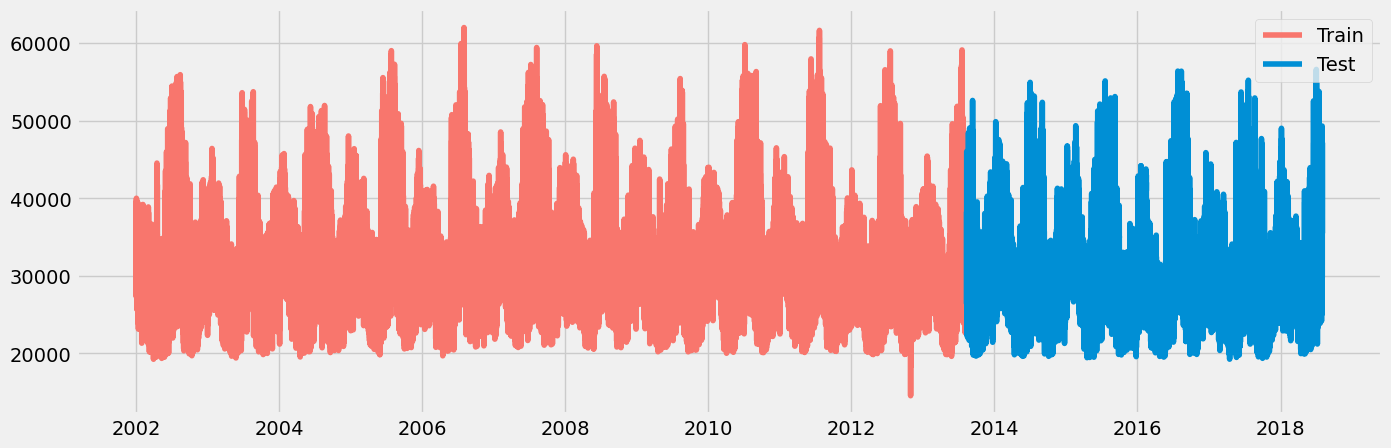

In [137]:
df = df.sort_index()

# Train and Test
train, test = np.split(df, [int(len(df) * .7)])

# Train
x_train, y_train = train.drop(columns = ['pjme']), train['pjme']
# Test
x_test, y_test = test.drop(columns = ['pjme']), test['pjme']

# Plot
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(train['pjme'], label = 'Train', color = color_pal[0])
ax.plot(test['pjme'], label = 'Test')
ax.legend(loc = 'upper right')
plt.show()

### XGBoost

In [138]:
reg = xgboost.XGBRegressor(n_estimators = 1000)
reg.fit(x_train, y_train
       , eval_set = [(x_train, y_train), (x_test, y_test)]
       , early_stopping_rounds = 50
       , verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

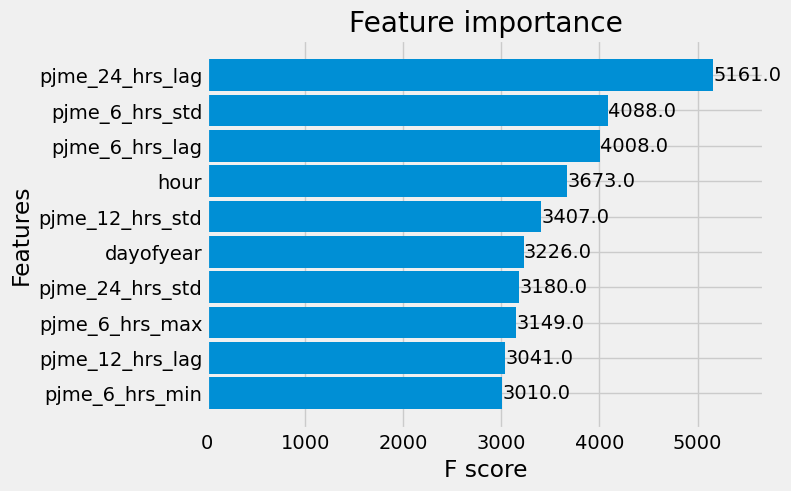

In [139]:
# Show features importance
_ = plot_importance(reg, height= 0.9, max_num_features = 10)

<div class = 'alert alert-info'>
    <p><b>Interpretation</b>: We can see that lag is the most important features followed , by min , max ,mean and std deviation.
    </p>
</div>

In [221]:
# Predict
y_test = pd.DataFrame(y_test)
y_test['forecast'] = reg.predict(x_test)

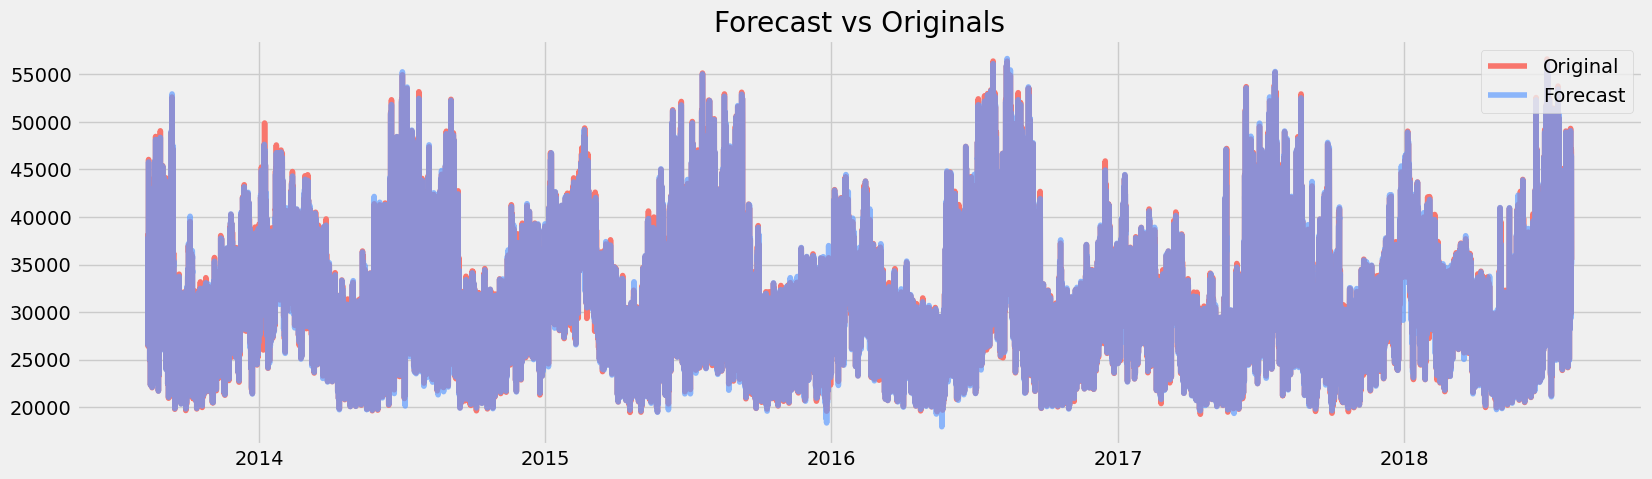

In [246]:
# Plot: Forecast vs Originals
fig, ax = plt.subplots(1, 1, figsize = (18, 5))
ax.plot(y_test['pjme'], label = 'Original', color = color_pal[0])
ax.plot(y_test['forecast'], label = 'Forecast', color = color_pal[6], alpha = .7)
ax.legend(loc = 'upper right')
ax.set_title('Forecast vs Originals')
plt.subplots_adjust(hspace = .5)
plt.show()

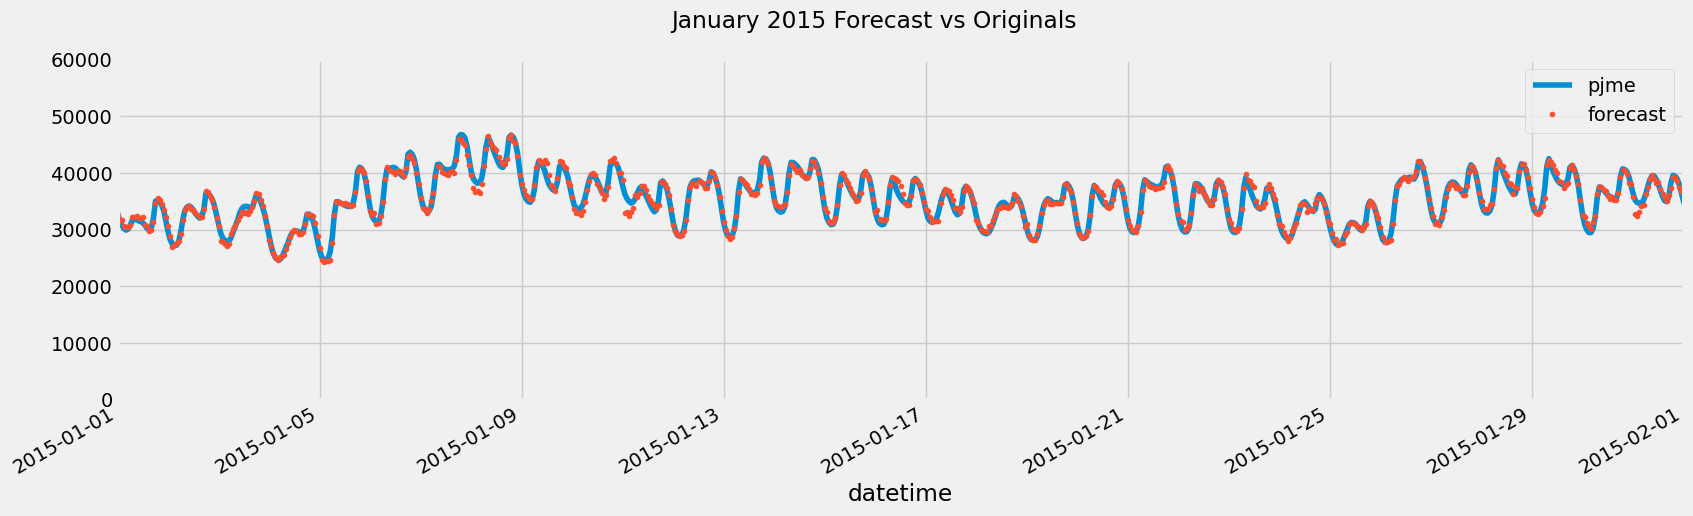

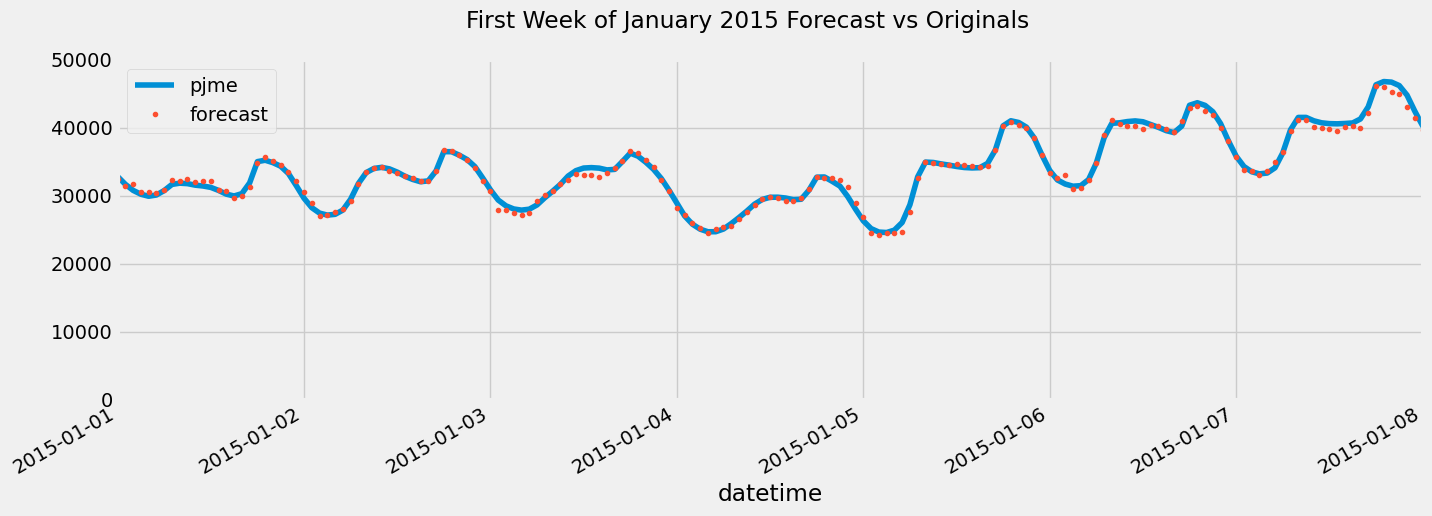

In [247]:
# Plot: January 2015
fig, ax = plt.subplots(1, 1, figsize = (18, 5))
_ = y_test[['pjme','forecast']].plot(ax = ax, style = ['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Originals')

# Plot: First Week of January 2015
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
_ = y_test[['pjme','forecast']].plot(ax = ax, style = ['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 50000)
plot = plt.suptitle('First Week of January 2015 Forecast vs Originals')
plt.show()

### Metrics

In [253]:
# RMSE and MAPE
rmse_xgb = np.sqrt(mean_squared_error(y_test['forecast'], y_test['pjme']))
mape_xgb = mean_absolute_percentage_error(y_test['forecast'], y_test['pjme'])

print(f'[RMSE]: {rmse_xgb:.2f}, [MAPE]: {mape_xgb:.2f}')

[RMSE]: 563.53, [MAPE]: 0.01
